#Steps:


1. Copy paste variant to "Blackbox NIDS Trainer" Section.

2. Set label ratio variable (around line 13)

3. Check out epoch no.s (at around line 27-29)

4. Delete import from nids_blackbox_data_generator (UPDATED: DO NOT)

5. Uncomment train_model() if you want to train

6. Update attack type at "Black Box Wrapper" section

7. Update attack type at "IDSGAN Data Loader" section (line 48)

8. Update functional_categories for attack type in "IDSGAN Train" section

9. Update functional_categories for attack type in "IDSGAN Result Generation" section.

10. Repeat steps (5-8) for different attack types.

-- Special Tip: Also check out the generated result after training at the end of the blackbox NIDS trainer section.

# Primary Loading

In [ ]:
! git clone https://github.com/tzpranto/NIDS_NSYSS_23

Cloning into 'idsgan18'...
remote: Enumerating objects: 668, done.
remote: Counting objects: 100% (668/668), done.
remote: Compressing objects: 100% (592/592), done.
remote: Total 668 (delta 78), reused 635 (delta 63), pack-reused 0
Receiving objects: 100% (668/668), 38.46 MiB | 8.16 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Checking out files: 100% (347/347), done.


In [ ]:
cd https://github.com/tzpranto/NIDS_NSYSS_23/idsgan18/

/content/idsgan18


In [ ]:
!ls -l

total 96
-rw-r--r--  1 root root  3083 Oct  1 10:14 BlackBox_IDS.py
-rw-r--r--  1 root root   887 Oct  1 10:14 blackbox_wrapper.py
drwxr-xr-x  2 root root  4096 Oct  1 10:14 clustering
drwxr-xr-x  2 root root  4096 Oct  1 10:14 dataset
-rw-r--r--  1 root root  5346 Oct  1 10:14 idsgan_data_loader.py
-rw-r--r--  1 root root  7032 Oct  1 10:14 idsgan_preprocessor.py
-rw-r--r--  1 root root  2543 Oct  1 10:14 idsgan_result_generation.py
-rw-r--r--  1 root root  7324 Oct  1 10:14 idsgan_train.py
drwxr-xr-x  3 root root  4096 Oct  1 10:14 model
drwxr-xr-x 30 root root  4096 Oct  1 10:14 models
-rw-r--r--  1 root root  6867 Oct  1 10:14 nids_blackbox_data_generator.py
-rw-r--r--  1 root root 28321 Oct  1 10:14 nids_loader.py
drwxr-xr-x  2 root root  4096 Oct  1 10:14 __pycache__
drwxr-xr-x  2 root root  4096 Oct  1 10:14 save_model


In [ ]:
! pip install scikit-learn==0.23.1

     |████████████████████████████████| 6.8 MB 2.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# NIDS Loader

In [ ]:
import os
import pickle

import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.patheffects as PathEffects
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances

from nids_blackbox_data_generator import get_training_data, dataset_test

debug = False
method = 'km'
label_ratio = 0.50
cluster_centroid_ratio = 100

np.random.seed(12345)
torch.manual_seed(12345)

random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

total_dataset, labeled_dataset, unlabeled_dataset = get_training_data(no_samples=125973, label_ratio=label_ratio)
cat_dict = total_dataset.get_cat_dict()
print(cat_dict)
test_dataset = dataset_test(cat_dict)

num_data = total_dataset.get_x()
labels = total_dataset.get_y()

# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(num_data)
# pca_result_test = pca.transform(test_dataset.get_x())
# print("Pca done!")
#
#
# def get_scatter(x, colors):
#     # choose a color palette with seaborn.
#     fig, ax = plt.subplots()
#     classes = np.unique(colors)
#     for c in classes:
#         x_, y_ = x[colors == c], c
#         ax.scatter(x_[:, 0], x_[:, 1], label=y_, lw=0, s=40)
#
#     ax.legend()
#     plt.show()
#
#
# get_scatter(pca_result, labels)

total_original_label_counts = dict()
distinct_labels, distinct_label_counts = np.unique(labels, return_counts=True)

for i in range(len(distinct_labels)):
    if distinct_labels[i] != -1:
        total_original_label_counts[distinct_labels[i]] = distinct_label_counts[i]


def tree_work(load_cluster_from_file=False):
    if load_cluster_from_file:
        clustering = pickle.load(
            file=open(os.path.join('clustering', 'nslkdd' + "_" + str(cluster_centroid_ratio) + ".pkl"), 'rb'))
    else:
        clustering = KMeans(n_clusters=int(total_dataset.__len__() / cluster_centroid_ratio), random_state=0)
        print("Clustering Started.")
        clustering.fit(num_data)
        print("Clustering ended.")

    all_cluster_centers = clustering.cluster_centers_
    closest, _ = pairwise_distances_argmin_min(num_data, all_cluster_centers)

    print(closest.shape)

    cluster_to_labels_dict = dict()
    for j in range(len(closest)):
        if labels[j] >= 0:
            cluster_to_labels_dict.setdefault(closest[j], []).append(labels[j])

    cluster_to_label_dict = dict()
    for k, v in cluster_to_labels_dict.items():
        un, cnt = np.unique(v, return_counts=True)
        un_idx = np.argmax(cnt)
        cluster_to_label_dict[k] = un[un_idx]

    print(cluster_to_label_dict)

    file = open(os.path.join('models', 'models_' +
                             str(method) + "_" + str(label_ratio), 'cluster_to_label_dict.pkl'), 'wb')
    pickle.dump(cluster_to_label_dict, file)
    file.close()

    file = open(os.path.join('models', 'models_' +
                             str(method) + "_" + str(label_ratio), 'all_cluster_centers.pkl'), 'wb')
    pickle.dump(all_cluster_centers, file)
    file.close()

    if not load_cluster_from_file:
        file = open(os.path.join('clustering', 'nslkdd' + "_" + str(cluster_centroid_ratio) + ".pkl"), 'wb')
        pickle.dump(clustering, file)
        file.close()


def generate_result(test_X, label_ratio_, test_Y=None, path_to_model='models'):

    cluster_to_label_dict = pickle.load(
        file=open(os.path.join(path_to_model, 'models_' + str(method) + "_" +
                               str(label_ratio_), 'cluster_to_label_dict.pkl'), 'rb'))

    cluster_to_label_dict = dict(cluster_to_label_dict)
    all_cluster_centers = pickle.load(
        file=open(os.path.join(path_to_model, 'models_' + str(method) + "_" +
                               str(label_ratio_), 'all_cluster_centers.pkl'), 'rb'))

    pd = pairwise_distances(X=test_X, Y=all_cluster_centers)
    pd_s = np.argsort(pd, axis=1)
    # print(pd_s.shape)

    test_Y_pred = np.zeros(test_X.shape[0])
    for i in range(len(pd_s)):
        for j in range(len(pd_s[i])):
            if pd_s[i][j] in cluster_to_label_dict.keys():
                test_Y_pred[i] = cluster_to_label_dict[pd_s[i][j]]
                break

    test_Y_pred = np.array(test_Y_pred)

    if test_Y is not None:
        test_Y_binary = np.zeros(test_Y.shape)
        test_Y_pred_binary = np.zeros(test_Y_pred.shape)

        for i in range(len(test_Y_pred)):
            if test_Y[i] != cat_dict['Normal']:
                test_Y_binary[i] = 1
            if test_Y_pred[i] != cat_dict['Normal']:
                test_Y_pred_binary[i] = 1

        print(confusion_matrix(test_Y, test_Y_pred))
        print(classification_report(test_Y, test_Y_pred))

        # print(confusion_matrix(test_Y_binary, test_Y_pred_binary))
        # print(classification_report(test_Y_binary, test_Y_pred_binary))

    return test_Y_pred


def train_model():
    if not os.path.exists('models'):
        os.mkdir('models')

    if not os.path.exists(os.path.join('models', 'models_' + str(method) + "_" + str(label_ratio))):
        os.mkdir(os.path.join('models', 'models_' + str(method) + "_" + str(label_ratio)))

    tree_work(load_cluster_from_file=True)


train_model()
total_dataset, labeled_dataset, unlabeled_dataset = get_training_data(no_samples=125973, label_ratio=1.0)
generate_result(total_dataset.get_x(), test_Y=total_dataset.get_y(), label_ratio_=label_ratio)
generate_result(test_dataset.get_x(), test_Y=test_dataset.get_y(), label_ratio_=label_ratio)

# total_dataset_s, labeled_dataset_s, unlabeled_dataset_s = get_training_data(no_samples=175341,
#                                                                             label_ratio=1.0, stratified=True)
#
# test_dataset_s = dataset_test(cat_dict, stratified_test=True)
#
# generate_result(total_dataset_s.get_x(), test_Y=total_dataset_s.get_y(), label_ratio_=label_ratio)
# generate_result(test_dataset_s.get_x(), test_Y=test_dataset_s.get_y(), label_ratio_=label_ratio)

# Black Box Wrapper

In [ ]:
class BlackBoxWrapper:
    def __init__(self, input_dim, output_dim, path_to_model='models'):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.path_to_model = path_to_model

    def __call__(self, x):
        x = x.cpu().detach().numpy()
        x = x.astype(float)
        y = self.getBinPrediction(x)
        y = torch.FloatTensor(y).to(device)
        return y

    def eval(self):

        return

    def getBinPrediction(self, x):
        pred_Y = generate_result(x, label_ratio_=label_ratio, path_to_model=self.path_to_model)
        bin_pred_y = []
        for y in pred_Y:
            if y == cat_dict["DoS"]:
                bin_pred_y.append(1)
            else:
                bin_pred_y.append(0)
        return np.array(bin_pred_y)

#DNN


In [ ]:
import torch
from torch import nn

class Blackbox_IDS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.Dropout(0.2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.Dropout(0.2),
            nn.LeakyReLU(True),
            nn.Linear(input_dim // 4, input_dim // 8),
            nn.LeakyReLU(True),
            nn.Linear(input_dim // 8, output_dim),
        )

    def forward(self, x):
        x = self.layer(x)
        x = torch.nn.Sigmoid()(x)
        return x


In [ ]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from idsgan_preprocessor import preprocess3, create_batch1
# from model.model_class import Blackbox_IDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = pd.read_csv('dataset/KDDTrain+.csv')
test = pd.read_csv('dataset/KDDTest+.csv')

trainx, trainy, testx, testy = preprocess3(train, test)
# trainx, _, trainy, _ = train_test_split(trainx, trainy, test_size=0.5, random_state=12345)

input_dim = trainx.shape[1]
output_dim = 1
batch_size = 64
tr_N = len(trainx)
te_N = len(testx)
ids_model = Blackbox_IDS(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(ids_model.parameters(), lr=0.001)
loss_f = torch.nn.BCELoss()
max_epoch = 50
train_losses, test_losses = [], []


def train(x, y):
    ids_model.train()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0
    for x, y in zip(batch_x, batch_y):
        ids_model.zero_grad()
        x_t = torch.FloatTensor(x).to(device)
        y_t = torch.FloatTensor(y).to(device)
        y_t = torch.reshape(y_t, [batch_size])

        out = ids_model(x_t)
        out = torch.reshape(out, [batch_size])

        loss = loss_f(out, y_t)

        run_loss += loss.item()
        loss.backward()
        optimizer.step()
    return run_loss / tr_N


def test(x, y):
    ids_model.eval()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0

    with torch.no_grad():
        for x, y in zip(batch_x, batch_y):
            x_t = torch.FloatTensor(x).to(device)
            y_t = torch.FloatTensor(y).to(device)
            y_t = torch.reshape(y_t, [batch_size])

            out = ids_model(x_t)
            out = torch.reshape(out, [batch_size])

            loss = loss_f(out, y_t)

            run_loss += loss.item()
    return run_loss / te_N


def main():
    print("IDS start training")
    print("-" * 100)
    for epoch in range(max_epoch):
        train_loss = train(trainx, trainy)
        test_loss = test(testx, testy)

        x_t = torch.FloatTensor(testx).to(device)

        out = ids_model(x_t)
        out = torch.reshape(out, [len(testy)])
        out_np = out.cpu().detach().numpy()

        ids_pred_label = np.array(out_np > 0.5).astype(int)

        correct = np.sum(np.equal(ids_pred_label, testy))
        acc = correct / len(testy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"{epoch} : {train_loss} \t {test_loss} \t {acc}")

    print("IDS finished training")

    x_t = torch.FloatTensor(testx).to(device)

    out = ids_model(x_t)
    out = torch.reshape(out, [len(testy)])
    out_np = out.cpu().detach().numpy()

    ids_pred_label = np.array(out_np > 0.5).astype(int)

    conf_mat = confusion_matrix(testy, ids_pred_label)
    print(conf_mat)

    torch.save(ids_model.state_dict(), 'model/IDS.pth')
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.legend()
    plt.show()

IDS start training
----------------------------------------------------------------------------------------------------
0 : 0.001603667558888593 	 0.024088641138174924 	 0.7650816181689141
1 : 0.0014328183404067516 	 0.0228069831635023 	 0.7435681334279631
2 : 0.0014315951755499916 	 0.025635523051340755 	 0.7538591199432222
3 : 0.001429098769125913 	 0.025978903188994797 	 0.7536816891412349
4 : 0.0014194524444937889 	 0.027638522159860776 	 0.7587384669978708
5 : 0.0014180715454657337 	 0.026347325029442547 	 0.7461408800567778
6 : 0.0014339814711241676 	 0.023876370678373563 	 0.7498225691980128
7 : 0.001403328682065855 	 0.02633300822590411 	 0.7565205819730305
8 : 0.0014218083764960668 	 0.024046106368430208 	 0.7490684882895671
9 : 0.0014232932399244884 	 0.026063164229444616 	 0.747028034066714
10 : 0.0014230929557677778 	 0.02653842670029998 	 0.7485361958836054
11 : 0.0014215941970705664 	 0.02678609240041336 	 0.747028034066714
12 : 0.0014085875609459277 	 0.02616141907833754

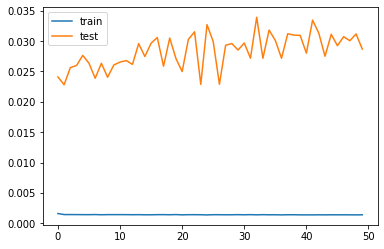

In [ ]:
main()

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = Blackbox_IDS(input_dim, output_dim).to(device)
        if os.path.exists('model/IDS.pth'):
            param = torch.load('model/IDS.pth')
            self.model.load_state_dict(param)
        else:
            print('BlackBox Model not saved yet')

    def __call__(self, x):
        # x = torch.reshape(x, [x.shape[0],1,-1])
        x = self.model(x)
        return x

    def eval(self):
        self.model.eval()

#RNN

In [ ]:
import torch
from torch import nn


class Blackbox_IDS(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 80, 1, batch_first=True)
        self.layer = nn.Sequential(
            nn.Dropout(0.1),
            nn.ReLU(True),
            nn.Linear(80, 40),
            nn.ReLU(True),
            nn.Linear(40, 20),
            nn.ReLU(True),
            nn.Linear(20, 5),
            nn.ReLU(True),
            nn.Linear(5, output_dim),
        )

    def forward(self, x):
        x = self.lstm(x)[0]
        x = torch.squeeze(x)
        x = self.layer(x)
        x = torch.nn.Sigmoid()(x)
        return x

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import confusion_matrix
from idsgan_preprocessor import preprocess3, create_batch1
#from model.model_class import Blackbox_IDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train = pd.read_csv('dataset/KDDTrain+.csv')
test = pd.read_csv('dataset/KDDTest+.csv')

trainx, trainy, testx, testy = preprocess3(train, test)
trainx, _, trainy, _ = train_test_split(trainx, trainy, test_size=0.5, random_state=12345)
print(trainx.shape)

input_dim = trainx.shape[1]
output_dim = 1
batch_size = 64
tr_N = len(trainx)
te_N = len(testx)
ids_model = Blackbox_IDS(input_dim, output_dim).to(device)
optimizer = torch.optim.Adam(ids_model.parameters(), lr=0.001)
loss_f = torch.nn.BCELoss()
max_epoch = 50
train_losses, test_losses = [], []


def train(x, y):
    ids_model.train()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0
    for x, y in zip(batch_x, batch_y):
        ids_model.zero_grad()
        x_t = torch.FloatTensor(x).to(device)
        x_t = torch.reshape(x_t, [batch_size,1,-1])
        y_t = torch.FloatTensor(y).to(device)
        y_t = torch.reshape(y_t, [batch_size])

        out = ids_model(x_t)
        out = torch.reshape(out, [batch_size])

        loss = loss_f(out, y_t)

        run_loss += loss.item()
        loss.backward()
        optimizer.step()
    return run_loss / tr_N


def test(x, y):
    ids_model.eval()
    batch_x, batch_y = create_batch1(x, y, batch_size)
    run_loss = 0

    with torch.no_grad():
        for x, y in zip(batch_x, batch_y):
            x_t = torch.FloatTensor(x).to(device)
            x_t = torch.reshape(x_t, [batch_size,1,-1])
            y_t = torch.FloatTensor(y).to(device)
            y_t = torch.reshape(y_t, [batch_size])

            out = ids_model(x_t)
            out = torch.reshape(out, [batch_size])

            loss = loss_f(out, y_t)

            run_loss += loss.item()
    return run_loss / te_N


def main():
    print("IDS start training")
    print("-" * 100)
    for epoch in range(max_epoch):
        train_loss = train(trainx, trainy)
        test_loss = test(testx, testy)

        x_t = torch.FloatTensor(testx).to(device)
        x_t = torch.reshape(x_t, [x_t.shape[0],1,-1])

        out = ids_model(x_t)
        out = torch.reshape(out, [len(testy)])
        out_np = out.cpu().detach().numpy()

        ids_pred_label = np.array(out_np > 0.5).astype(int)

        correct = np.sum(np.equal(ids_pred_label, testy))
        acc = correct / len(testy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"{epoch} : {train_loss} \t {test_loss} \t {acc}")

    print("IDS finished training")

    x_t = torch.FloatTensor(testx).to(device)
    x_t = torch.reshape(x_t, [x_t.shape[0],1,-1])
    out = ids_model(x_t)
    out = torch.reshape(out, [len(testy)])
    out_np = out.cpu().detach().numpy()

    ids_pred_label = np.array(out_np > 0.5).astype(int)

    conf_mat = confusion_matrix(testy, ids_pred_label)
    print(conf_mat)

    torch.save(ids_model.state_dict(), 'model/IDS.pth')
    plt.plot(train_losses, label="train")
    plt.plot(test_losses, label="test")
    plt.legend()
    plt.show()

In [ ]:
main()

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.model = Blackbox_IDS(input_dim, output_dim).to(device)
        if os.path.exists('model/IDS.pth'):
            param = torch.load('model/IDS.pth')
            self.model.load_state_dict(param)
        else:
            print('BlackBox Model not saved yet')

    def __call__(self, x):
        x = torch.reshape(x, [x.shape[0],1,-1])
        x = self.model(x)
        return x

    def eval(self):
        self.model.eval()

#Training Fuzzyness IDS

In [ ]:
percent = 0.5
normal_index = 1

##Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import pprint
from pickle import dump

from sklearn.preprocessing import StandardScaler

pp = pprint.PrettyPrinter(indent=4)
debug = False

NSLKDD_ATTACK_DICT = {
    'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'Privilege': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm','httptunnel'],
    'Access': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail',
               'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop','worm'],
    'Normal': ['normal']
}


NSLKDD_COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class", "difficulty_level"]

binary = False

NSLKDD_ATTACK_MAP = dict()
for k, v in NSLKDD_ATTACK_DICT.items():
    for att in v:
        if not binary:
            NSLKDD_ATTACK_MAP[att] = k
        else:
            if k == 'Normal':
                NSLKDD_ATTACK_MAP[att] = k
            else:
                NSLKDD_ATTACK_MAP[att] = 'Attack'


FEATURE_CATEGORY = dict()

for i in range(9):
    FEATURE_CATEGORY.setdefault('intrinsic', []).append(NSLKDD_COL_NAMES[i])

for i in range(9, 22):
    FEATURE_CATEGORY.setdefault('content', []).append(NSLKDD_COL_NAMES[i])

for i in range(22, 31):
    FEATURE_CATEGORY.setdefault('time_based', []).append(NSLKDD_COL_NAMES[i])

for i in range(32, 41):
    FEATURE_CATEGORY.setdefault('host_based', []).append(NSLKDD_COL_NAMES[i])


FEATURE_CATEGORY_REV = dict()

for k,v in FEATURE_CATEGORY.items():
    for cat in list(v):
        FEATURE_CATEGORY_REV[cat] = k


FEATURE_TYPE = dict()

for i in [2, 3, 4]:
    FEATURE_TYPE.setdefault('categorical', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [7, 12, 14, 20, 21, 22]:
    FEATURE_TYPE.setdefault('binary', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [8, 9, 15, 43] + list(range(23, 42)):
    FEATURE_TYPE.setdefault('discrete', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [1, 5, 6, 10, 11, 13, 16, 17, 18, 19]:
    FEATURE_TYPE.setdefault('continuous', []).append(NSLKDD_COL_NAMES[i - 1])


def create_batch1(x, y, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]

    batch_x = [x[batch_size * i: (i + 1) * batch_size, :].tolist() for i in range(len(x) // batch_size)]
    batch_y = [y[batch_size * i: (i + 1) * batch_size].tolist() for i in range(len(x) // batch_size)]
    return batch_x, batch_y


def create_batch2(x, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i: (i + 1) * batch_size, :] for i in range(len(x) // batch_size)]
    return np.array(batch_x).astype(float)


def preprocess4(train, functional_categories=None):
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)

    raw_attack = np.array(train[train["class"] == 1])[:, :-1]
    normal = np.array(train[train["class"] == 0])[:, :-1]
    true_label = train["class"]

    del train["class"]

    train_columns = list(train.columns)

    modification_mask = np.ones((len(train.columns)))
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']

    for cat_ in functional_categories:
        cat_cols = list(FEATURE_CATEGORY[cat_])
        for cat_col in cat_cols:
            for idx in range(len(train_columns)):
                if str(train_columns[idx]).startswith(cat_col):
                    modification_mask[idx] = 0

    return train, raw_attack, normal, true_label, modification_mask


# all
def preprocess2(train, test, data_generation=False, attack_map=None):
    train.drop(['difficulty_level'], axis=1, inplace=True)
    test.drop(['difficulty_level'], axis=1, inplace=True)

    train.sample(frac=1)

    obj_cols = train.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != 'class':
            onehot_cols_train = pd.get_dummies(train[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(test[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(train.columns))):
                if list(train.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                train.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(test.values.shape[0])
                    test.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    test.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                itr += 1

            del train[col]
            del test[col]

    if not data_generation:
        train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
        test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)
    else:
        train["class"] = train["class"].map(attack_map)
        test["class"] = test["class"].map(attack_map)

    columns = train.columns
    train["num_outbound_cmds"] = train["num_outbound_cmds"].map(lambda x: 0)
    test["num_outbound_cmds"] = test["num_outbound_cmds"].map(lambda x: 0)

    if not data_generation:
        trainx, trainy = np.array(train[train.columns[train.columns != "class"]]), np.array(train["class"])
        testx, testy = np.array(test[train.columns[train.columns != "class"]]), np.array(test["class"])

        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        return trainx, trainy, testx, testy
    else:
        trainx, trainy = train[train.columns[train.columns != "class"]], train["class"]
        testx, testy = test[train.columns[train.columns != "class"]], test["class"]

        columns = trainx.columns
        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        train_processed = pd.DataFrame(trainx, columns=columns)
        train_processed["class"] = trainy

        test_processed = pd.DataFrame(testx, columns=columns)
        test_processed["class"] = testy

        return train_processed, test_processed


def preprocess3(train, test):
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
    test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)

    train_np = train.values
    test_np = test.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    testx, testy = test_np[:, :-1], test_np[:, -1]

    testy = np.array(testy).astype(int)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy, testx, testy



def preprocess5(train):
    #print(train["class"])
    #train["class"] = train["class"].map(NSLKDD_ATTACK_MAP)
    train["class"] = train["class"].astype('category')
    #print(train["class"].cat.categories)
    cat_dict_r = dict(enumerate(train["class"].cat.categories))
    cat_dict = dict()

    #print("Cat dict R")
    #print(cat_dict_r)
    for key, value in cat_dict_r.items():
        cat_dict[value] = key

    #print("Cat dict")
    #print(cat_dict)

    train = train.replace({"class": cat_dict})
    #print(train["class"])
    train["class"] = train["class"].astype('int64')

    train_np = train.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    #print(trainy)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy

##Model

In [ ]:
from idsgan_preprocessor import preprocess3
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from math import log
import sys
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


train = pd.read_csv('dataset/KDDTrain+.csv')
test = pd.read_csv('dataset/KDDTest+.csv')

trainx, trainy = preprocess5(train)
testx, testy = preprocess5(test)
#print(np.unique(trainy, return_counts=True))
#print(np.unique(testy, return_counts=True))

trainx, valx, trainy, valy = train_test_split(trainx, trainy, test_size=percent, random_state=12345)

# valx = np.array([])
# valy = np.array([1,2,3,0,4])
#print(trainy[0], testy[0])

trainy = pd.DataFrame(to_categorical(trainy, 5)).values
valy = pd.DataFrame(to_categorical(valy, 5)).values
testy = pd.DataFrame(to_categorical(testy, 5)).values

#print(trainy[0], testy[0])
print(trainx.shape, trainy.shape)
print(valx.shape, valy.shape)
print(testx.shape, testy.shape)

In [ ]:
def train_classifier(X, y):
    # create model
    model = Sequential()
    #model.add(Dense(40, input_dim=122, kernel_initializer='random_normal',bias_initializer='random_normal', activation='relu'))
    model.add(Dense(80, input_dim=122, activation='relu'))
    #model.add(Dense(60, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the model
    model.fit(X, y, epochs=200, batch_size=256)

    return model


model = train_classifier(trainx, trainy)

score = model.evaluate(testx, testy)

print("Accuracy: ", score[1])

In [ ]:
membershipVectors = model.predict(valx) # Membership Matriloc
binarizedLabels = (membershipVectors == membershipVectors.max(axis=1, keepdims=1)).astype(float)

def F(V):
    def inner(mu):
        try:
            result = (mu * log(mu, 2)) + ((1 - mu) * log(1 - mu, 2))
        except:
            result = 0
        return result
    return - np.mean(list(map(inner, V)))

fuzziness = np.array(list(map(F, membershipVectors)))

print(fuzziness[0])

In [ ]:
#lowFuzzinessIndices = np.append(np.where( fuzziness >= 9/10), np.where( fuzziness <= 1/10 ) )
lowFuzzinessIndices = np.where( fuzziness <= 1/10 )
highFuzzinessIndices = np.logical_and(fuzziness >= 2/6, fuzziness <= 2/3)

# Fuzziness values >= 5/6
lowFuzzinessGroup = valx[ lowFuzzinessIndices ]
lowFuzzinessLabels = binarizedLabels[ lowFuzzinessIndices ]

# Fuzziness values 2/6 <= x <= 2/3
highFuzzinessGroup = valx[ highFuzzinessIndices ]
highFuzzinessLabels = binarizedLabels [ highFuzzinessIndices ]

# Append new samples to training set
#train_set_x = np.concatenate((train_set_x, lowFuzzinessGroup, highFuzzinessGroup), axis=0)

#train_set_y = np.concatenate((train_set_y, lowFuzzinessLabels, highFuzzinessLabels), axis=0)
trainx = np.concatenate((trainx, lowFuzzinessGroup), axis=0)

trainy = np.concatenate((trainy, lowFuzzinessLabels), axis=0)

In [ ]:
print(trainx.shape)
print(trainy.shape)
model = train_classifier(trainx, trainy)
score = model.evaluate(testx, testy)

print("Accuracy: ", score[1])

##BlackBox IDS

In [ ]:
def getPred(x):
    y = model.predict(x)
    y_c = y.argmax(axis=-1)
    y_bin = []
    for val in y_c:
        if val == normal_index:
            y_bin.append(0)
        else:
            y_bin.append(1)
    return np.array(y_bin)

In [ ]:
import os
class BlackBoxWrapper():
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

    def __call__(self, x):
        x = x.cpu().detach().numpy()
        x = getPred(x)
        x = torch.FloatTensor(x).to(device)
        return x

    def eval(self):
        x = 1

# IDSGAN Preprocessor

In [ ]:
import pandas as pd
import numpy as np
import pprint
from pickle import dump

from sklearn.preprocessing import StandardScaler

pp = pprint.PrettyPrinter(indent=4)

NSLKDD_COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class", "difficulty_level"]

FEATURE_CATEGORY = dict()

for i in range(9):
    FEATURE_CATEGORY.setdefault('intrinsic', []).append(NSLKDD_COL_NAMES[i])

for i in range(9, 22):
    FEATURE_CATEGORY.setdefault('content', []).append(NSLKDD_COL_NAMES[i])

for i in range(22, 31):
    FEATURE_CATEGORY.setdefault('time_based', []).append(NSLKDD_COL_NAMES[i])

for i in range(32, 41):
    FEATURE_CATEGORY.setdefault('host_based', []).append(NSLKDD_COL_NAMES[i])


FEATURE_CATEGORY_REV = dict()

for k,v in FEATURE_CATEGORY.items():
    for cat in list(v):
        FEATURE_CATEGORY_REV[cat] = k


FEATURE_TYPE = dict()

for i in [2, 3, 4]:
    FEATURE_TYPE.setdefault('categorical', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [7, 12, 14, 20, 21, 22]:
    FEATURE_TYPE.setdefault('binary', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [8, 9, 15, 43] + list(range(23, 42)):
    FEATURE_TYPE.setdefault('discrete', []).append(NSLKDD_COL_NAMES[i - 1])

for i in [1, 5, 6, 10, 11, 13, 16, 17, 18, 19]:
    FEATURE_TYPE.setdefault('continuous', []).append(NSLKDD_COL_NAMES[i - 1])


def create_batch1(x, y, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    y = y[a]

    batch_x = [x[batch_size * i: (i + 1) * batch_size, :].tolist() for i in range(len(x) // batch_size)]
    batch_y = [y[batch_size * i: (i + 1) * batch_size].tolist() for i in range(len(x) // batch_size)]
    return batch_x, batch_y


def create_batch2(x, batch_size):
    a = list(range(len(x)))
    np.random.shuffle(a)
    x = x[a]
    batch_x = [x[batch_size * i: (i + 1) * batch_size, :] for i in range(len(x) // batch_size)]
    return np.array(batch_x).astype(float)


def preprocess4(train, functional_categories=None):
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)

    raw_attack = np.array(train[train["class"] == 1])[:, :-1]
    normal = np.array(train[train["class"] == 0])[:, :-1]
    true_label = train["class"]

    del train["class"]

    train_columns = list(train.columns)

    modification_mask = np.ones((len(train.columns)))
    if functional_categories is None:
        functional_categories = ['intrinsic', 'time_based']

    for cat_ in functional_categories:
        cat_cols = list(FEATURE_CATEGORY[cat_])
        for cat_col in cat_cols:
            for idx in range(len(train_columns)):
                if str(train_columns[idx]).startswith(cat_col):
                    modification_mask[idx] = 0

    return train, raw_attack, normal, true_label, modification_mask


# all
def preprocess2(train, test, data_generation=False, attack_map=None):
    train.drop(['difficulty_level'], axis=1, inplace=True)
    test.drop(['difficulty_level'], axis=1, inplace=True)

    train.sample(frac=1)

    obj_cols = train.select_dtypes(include=['object']).copy().columns
    obj_cols = list(obj_cols)

    for col in obj_cols:

        if col != 'class':
            onehot_cols_train = pd.get_dummies(train[col], prefix=col, dtype='float64')
            onehot_cols_test = pd.get_dummies(test[col], prefix=col, dtype='float64')

            idx = 0
            for find_col_idx in range(len(list(train.columns))):
                if list(train.columns)[find_col_idx] == col:
                    idx = find_col_idx

            itr = 0
            for new_col in list(onehot_cols_train.columns):
                train.insert(idx + itr + 1, new_col, onehot_cols_train[new_col].values, True)

                if new_col not in list(onehot_cols_test.columns):
                    zero_col = np.zeros(test.values.shape[0])
                    test.insert(idx + itr + 1, new_col, zero_col, True)
                else:
                    test.insert(idx + itr + 1, new_col, onehot_cols_test[new_col].values, True)

                itr += 1

            del train[col]
            del test[col]

    if not data_generation:
        train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
        test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)
    else:
        train["class"] = train["class"].map(attack_map)
        test["class"] = test["class"].map(attack_map)

    columns = train.columns
    train["num_outbound_cmds"] = train["num_outbound_cmds"].map(lambda x: 0)
    test["num_outbound_cmds"] = test["num_outbound_cmds"].map(lambda x: 0)

    if not data_generation:
        trainx, trainy = np.array(train[train.columns[train.columns != "class"]]), np.array(train["class"])
        testx, testy = np.array(test[train.columns[train.columns != "class"]]), np.array(test["class"])

        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        return trainx, trainy, testx, testy
    else:
        trainx, trainy = train[train.columns[train.columns != "class"]], train["class"]
        testx, testy = test[train.columns[train.columns != "class"]], test["class"]

        columns = trainx.columns
        scaler = StandardScaler()
        scaler.fit(trainx)

        trainx = scaler.transform(trainx)
        testx = scaler.transform(testx)

        train_processed = pd.DataFrame(trainx, columns=columns)
        train_processed["class"] = trainy

        test_processed = pd.DataFrame(testx, columns=columns)
        test_processed["class"] = testy

        return train_processed, test_processed


def preprocess3(train, test):
    train["class"] = train["class"].map(lambda x: 1 if x != "Normal" else 0)
    test["class"] = test["class"].map(lambda x: 1 if x != "Normal" else 0)

    train_np = train.values
    test_np = test.values

    trainx, trainy = train_np[:, :-1], train_np[:, -1]
    testx, testy = test_np[:, :-1], test_np[:, -1]

    testy = np.array(testy).astype(int)
    trainy = np.array(trainy).astype(int)

    return trainx, trainy, testx, testy


# IDSGAN Data Loader

In [ ]:
import numpy as np
import pandas as pd
import torch
from idsgan_preprocessor import preprocess2

np.random.seed(12345)
torch.manual_seed(12345)

import random

random.seed(12345)

NSLKDD_ATTACK_DICT = {
    'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm'],
    'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm', 'httptunnel'],
    'R2L': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail',
            'snmpgetattack', 'snmpguess', 'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop', 'worm'],
    'Normal': ['normal']
}

NSLKDD_COL_NAMES = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                    "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                    "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                    "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                    "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "class", "difficulty_level"]

binary = False

NSLKDD_ATTACK_MAP = dict()
for k, v in NSLKDD_ATTACK_DICT.items():
    for att in v:
        if not binary:
            NSLKDD_ATTACK_MAP[att] = k
        else:
            if k == 'Normal':
                NSLKDD_ATTACK_MAP[att] = k
            else:
                NSLKDD_ATTACK_MAP[att] = 'Attack'

max_weight = 100

considered_attack_list = ['DoS']

train = pd.read_csv('dataset/KDDTrain+.txt', delimiter=',', header=None, names=NSLKDD_COL_NAMES)
test = pd.read_csv('dataset/KDDTest+.txt', delimiter=',', header=None, names=NSLKDD_COL_NAMES)

train, test = preprocess2(train, test, data_generation=True, attack_map=NSLKDD_ATTACK_MAP)

blackbox_train = pd.DataFrame(columns=NSLKDD_COL_NAMES)
discriminator_train_normal = pd.DataFrame(columns=NSLKDD_COL_NAMES)
generator_train = pd.DataFrame(columns=NSLKDD_COL_NAMES)

GAN_train = pd.DataFrame(columns=NSLKDD_COL_NAMES)

generator_test_attack = pd.DataFrame(columns=NSLKDD_COL_NAMES)
generator_test_normal = pd.DataFrame(columns=NSLKDD_COL_NAMES)
generator_test_combined = pd.DataFrame(columns=NSLKDD_COL_NAMES)

train_id_dict = dict()

test_id_dict = dict()

for i in range(len(train)):
    train_id_dict.setdefault(train["class"][i], []).append(i)

for i in range(len(test)):
    test_id_dict.setdefault(test["class"][i], []).append(i)

blackbox_train_ids = []
discriminator_train_normal_ids = []
generator_train_ids = []

GAN_train_ids = []

generator_test_attack_ids = []
generator_test_normal_ids = []
generator_test_combined_ids = []



for k, v in train_id_dict.items():
    if k == "Normal":
        np.random.shuffle(v)
        blackbox_train_ids = blackbox_train_ids + v[:(len(v) // 2)]
        discriminator_train_normal_ids = discriminator_train_normal_ids + v[(len(v) // 2):]
    else:
        np.random.shuffle(v)
        if k in considered_attack_list:
            generator_train_ids = generator_train_ids + v[(len(v) // 2):]
        blackbox_train_ids = blackbox_train_ids + v[:(len(v) // 2)]

for k, v in test_id_dict.items():
    if k == "Normal":
        generator_test_normal_ids = generator_test_normal_ids + v
    else:
        if k in considered_attack_list:
            generator_test_attack_ids = generator_test_attack_ids + v

generator_test_combined_ids = generator_test_combined_ids + generator_test_normal_ids
generator_test_combined_ids = generator_test_combined_ids + generator_test_attack_ids

GAN_train_ids = GAN_train_ids + discriminator_train_normal_ids
GAN_train_ids = GAN_train_ids + generator_train_ids

blackbox_train = train.iloc[blackbox_train_ids]
pd.DataFrame.to_csv(blackbox_train, 'dataset/blackbox_train.csv', index=False)

discriminator_train_normal = train.iloc[discriminator_train_normal_ids]
pd.DataFrame.to_csv(discriminator_train_normal, 'dataset/discriminator_train_normal.csv', index=False)

generator_train = train.iloc[generator_train_ids]
pd.DataFrame.to_csv(generator_train, 'dataset/generator_train.csv', index=False)

generator_test_attack = test.iloc[generator_test_attack_ids]
pd.DataFrame.to_csv(generator_test_attack, 'dataset/generator_test_attack.csv', index=False)

generator_test_normal = test.iloc[generator_test_normal_ids]
pd.DataFrame.to_csv(generator_test_normal, 'dataset/generator_test_normal.csv', index=False)

generator_test_combined = test.iloc[generator_test_combined_ids]
pd.DataFrame.to_csv(generator_test_combined, 'dataset/generator_test_combined.csv', index=False)

GAN_train = train.iloc[GAN_train_ids]
pd.DataFrame.to_csv(GAN_train, 'dataset/GAN_train.csv', index=False)

# pd.DataFrame.to_csv(test, 'dataset/KDDTest+.csv', index=False)
# pd.DataFrame.to_csv(train, 'dataset/KDDTrain+.csv', index=False)


# IDSGAN Train

IDSGAN start training
----------------------------------------------------------------------------------------------------
Epoch: 0 -- Curr: 0.8141592920353983, Min 0.8141592920353983
Epoch: 1 -- Curr: 0.8171091445427728, Min 0.8141592920353983
Epoch: 2 -- Curr: 0.8234111021721641, Min 0.8141592920353983
Epoch: 3 -- Curr: 0.8805309734513275, Min 0.8141592920353983
Epoch: 4 -- Curr: 0.8944757307589166, Min 0.8141592920353983
Epoch: 5 -- Curr: 0.8791901314025208, Min 0.8141592920353983
Epoch: 6 -- Curr: 0.8168409761330115, Min 0.8141592920353983
Epoch: 7 -- Curr: 0.7889514615178332, Min 0.7889514615178332
Epoch: 8 -- Curr: 0.7902923035666398, Min 0.7889514615178332
Epoch: 9 -- Curr: 0.8272995441137034, Min 0.7889514615178332
Epoch: 10 -- Curr: 0.881871815500134, Min 0.7889514615178332
Epoch: 11 -- Curr: 0.9026548672566371, Min 0.7889514615178332
Epoch: 12 -- Curr: 0.8731563421828908, Min 0.7889514615178332
Epoch: 13 -- Curr: 0.644945025475999, Min 0.644945025475999
Epoch: 14 -- Curr: 0.2

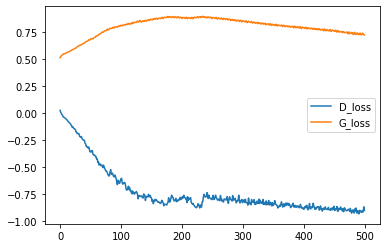

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim

# from blackbox_wrapper import BlackBoxWrapper
from idsgan_preprocessor import preprocess4, create_batch2
from model.model_class import Generator, Discriminator

np.random.seed(12345)
torch.manual_seed(12345)
random.seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

functional_categories = ['intrinsic', 'time_based']
#functional_categories = ['intrinsic', 'time_based', 'host_based']
#functional_categories = ['intrinsic', 'content']


data = pd.read_csv("dataset/GAN_train.csv")
train_data, raw_attack, normal, true_label, modification_mask \
    = preprocess4(data, functional_categories=functional_categories)

test = pd.read_csv("dataset/generator_test_combined.csv")
test, test_raw_attack, _, _, modification_mask_test = preprocess4(test, functional_categories)
test_raw_attack = np.array(test_raw_attack).astype(float)

modification_mask_test = np.tile(modification_mask_test, [len(test_raw_attack), 1])
modification_mask_test_t = torch.FloatTensor(modification_mask_test).to(device)

BATCH_SIZE = 256  # Batch size
GEN_ITERS = 20
CRITIC_ITERS = 1  # For WGAN and WGAN-GP, number of critic iters per gen iter
LAMBDA = 10  # Gradient penalty lambda hyperparameter
MAX_EPOCH = 500  # How many generator iterations to train for
NOISE_SIZE = 27
generator_input_dim = train_data.shape[1] + NOISE_SIZE
generator_output_dim = train_data.shape[1]
discriminator_output_dim = 1
CLAMP = 0.01

# read parameters of IDS

modification_mask = np.tile(modification_mask, [BATCH_SIZE, 1])
modification_mask_t = torch.FloatTensor(modification_mask).to(device)

ids_model = BlackBoxWrapper(generator_output_dim, 1)

# read model


def test_GAN(learned_g):
    # g_param = torch.load('save_model/generator.pth')
    # learned_g.load_state_dict(g_param)
    noise = np.random.uniform(0., 1., (len(test_raw_attack), NOISE_SIZE))
    gen_x = np.concatenate([test_raw_attack, noise], axis=1)

    gen_x_t = torch.FloatTensor(gen_x).to(device)

    adversarial_attack_modification_l = learned_g(gen_x_t, modification_mask_test_t)
    adversarial_attack_l = torch.FloatTensor(test_raw_attack).to(device) + adversarial_attack_modification_l

    out = ids_model(adversarial_attack_l)
    out = torch.reshape(out, [len(adversarial_attack_l)])
    out_np = out.cpu().detach().numpy()

    ids_pred_label = np.array(out_np > 0.5).astype(int)
    corr = np.sum(ids_pred_label)

    adv_det_rate_learned = corr / len(test_raw_attack)

    return adv_det_rate_learned


generator = Generator(generator_input_dim, generator_output_dim).to(device)
discriminator = Discriminator(generator_output_dim, discriminator_output_dim).to(device)

optimizer_G = optim.RMSprop(generator.parameters(), lr=0.0001)
optimizer_D = optim.RMSprop(discriminator.parameters(), lr=0.0001)

batch_attack = create_batch2(raw_attack, BATCH_SIZE)
batch_normal = create_batch2(normal, BATCH_SIZE)

d_losses, g_losses = [], []
ids_model.eval()
generator.train()
discriminator.train()
cnt = -5
print("IDSGAN start training")
print("-" * 100)

gen_attack_batch_idx = 0
dis_normal_batch_idx = 0
adv_dr = 1.00

for epoch in range(MAX_EPOCH):

    #  Train Generator

    gen_loss = 0.
    for g in range(GEN_ITERS):

        for p in generator.parameters():
            p.requires_grad = True

        for p in discriminator.parameters():
            p.requires_grad = False

        ba = batch_attack[gen_attack_batch_idx]
        gen_attack_batch_idx = (gen_attack_batch_idx + 1) % len(batch_attack)

        optimizer_G.zero_grad()

        noise = np.random.uniform(0., 1., (BATCH_SIZE, NOISE_SIZE))
        gen_x = np.concatenate([ba, noise], axis=1)

        gen_x_t = torch.FloatTensor(gen_x).to(device)

        adversarial_attack_modification = generator(gen_x_t, modification_mask_t)
        adversarial_attack = torch.FloatTensor(ba).to(device) + adversarial_attack_modification

        D_pred = discriminator(adversarial_attack)
        g_loss = torch.mean(D_pred)
        # print("G loss")
        # print(g_loss)
        # print("\n")

        g_loss.backward()
        optimizer_G.step()

        for p in generator.parameters():
            p = torch.clamp(p, -0.01, 0.01)

        gen_loss += g_loss.item()

    gen_loss = gen_loss / GEN_ITERS

    for p in discriminator.parameters():
        p.requires_grad = True

    for p in generator.parameters():
        p.requires_grad = False

    dis_loss = 0.
    for c in range(CRITIC_ITERS):
        optimizer_D.zero_grad()

        np.random.shuffle(batch_normal)

        bn = batch_normal[dis_normal_batch_idx]
        ba = batch_attack[dis_normal_batch_idx % len(batch_attack)]
        dis_normal_batch_idx = (dis_normal_batch_idx + 1) % len(batch_normal)

        noise = np.random.uniform(0., 1., (BATCH_SIZE, NOISE_SIZE))
        gen_x = np.concatenate([ba, noise], axis=1)

        gen_x_t = torch.FloatTensor(gen_x).to(device)

        adversarial_attack_modification = generator(gen_x_t, modification_mask_t)
        adversarial_attack_t = torch.FloatTensor(ba).to(device) + adversarial_attack_modification
        adversarial_attack = adversarial_attack_t.cpu().detach().numpy()

        ids_input = np.concatenate([bn, adversarial_attack], axis=0)

        l = list(range(len(ids_input)))
        np.random.shuffle(l)

        ids_input = ids_input[l]

        ids_input = torch.FloatTensor(ids_input).to(device)

        out = ids_model(ids_input)
        out = torch.reshape(out, [len(ids_input)])
        out_np = out.cpu().detach().numpy()

        ids_pred_label = np.array(out_np > 0.5).astype(int)

        pred_normal = ids_input.cpu().detach().numpy()[ids_pred_label == 0]
        pred_attack = ids_input.cpu().detach().numpy()[ids_pred_label == 1]

        # print(len(pred_normal))
        # print(len(pred_attack))

        if len(pred_attack) == 0:
            cnt += 1
            break

        D_normal = discriminator(torch.FloatTensor(pred_normal).to(device))
        D_attack = discriminator(torch.FloatTensor(pred_attack).to(device))
        D_adv = discriminator(adversarial_attack_t)

        loss_normal = torch.mean(D_normal)
        loss_attack = torch.mean(D_attack)
        loss_adv = torch.mean(D_adv)

        # print(loss_normal)
        # print(loss_attack)
        # print(loss_adv)
        # print("\n")

        d_loss = (loss_normal - loss_attack)  # + LAMBDA * gradient_penalty
        dis_loss += d_loss.item()

        d_loss.backward()
        optimizer_D.step()

        for p in discriminator.parameters():
            p = torch.clamp(p, -0.01, 0.01)

    dis_loss = dis_loss / CRITIC_ITERS

    d_losses.append(dis_loss)
    g_losses.append(gen_loss)

    adv_dr_curr = test_GAN(generator)
    if adv_dr_curr < adv_dr or epoch == 0:
        adv_dr = adv_dr_curr
        torch.save(generator.state_dict(), 'save_model/generator.pth')
        torch.save(discriminator.state_dict(), 'save_model/discreminator.pth')

    print("Epoch: {} -- Curr: {}, Min {}".format(epoch, adv_dr_curr, adv_dr))

    if cnt >= 100:
        print("Not exist predicted attack traffic")
        break

print("IDSGAN finish training")
plt.plot(d_losses, label="D_loss")
plt.plot(g_losses, label="G_loss")
plt.legend()
plt.show()

# IDSGAN Result Generation

In [ ]:
import numpy as np
import pandas as pd
import torch

# from blackbox_wrapper import BlackBoxWrapper
from model.model_class import Generator
from idsgan_preprocessor import preprocess4
import random

np.random.seed(12345)
torch.manual_seed(12345)
random.seed(12345)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test = pd.read_csv("dataset/generator_test_combined.csv")

functional_categories = ['intrinsic', 'time_based']
# functional_categories = ['intrinsic', 'time_based', 'host_based']
# functional_categories = ['intrinsic', 'content']


test, raw_attack, _, _, modification_mask = preprocess4(test, functional_categories)
raw_attack = np.array(raw_attack).astype(float)

modification_mask = np.tile(modification_mask, [len(raw_attack), 1])
modification_mask_t = torch.FloatTensor(modification_mask).to(device)

NOISE_SIZE = 27
generator_input_dim = test.shape[1] + NOISE_SIZE
generator_output_dim = test.shape[1]
discriminator_output_dim = 1

random_g = Generator(generator_input_dim, generator_output_dim)
learned_g = Generator(generator_input_dim, generator_output_dim).to(device)

ids_model = BlackBoxWrapper(generator_output_dim, 1)

x_t = torch.FloatTensor(raw_attack).to(device)

out = ids_model(x_t)
out = torch.reshape(out, [len(raw_attack)])
out_np = out.cpu().detach().numpy()

ids_pred_label = np.array(out_np > 0.5).astype(int)
corr = np.sum(ids_pred_label)

original_det_rate = corr / len(raw_attack)

print("original detection rate : {}".format(original_det_rate))


def test_GAN():
    g_param = torch.load('save_model/generator.pth')
    learned_g.load_state_dict(g_param)

    noise = np.random.uniform(0., 1., (len(raw_attack), NOISE_SIZE))
    gen_x = np.concatenate([raw_attack, noise], axis=1)

    gen_x_t = torch.FloatTensor(gen_x).to(device)

    adversarial_attack_modification_l = learned_g(gen_x_t, modification_mask_t)
    adversarial_attack_l = torch.FloatTensor(raw_attack).to(device) + adversarial_attack_modification_l

    # print(np.min(adversarial_attack_modification_l.cpu().detach().numpy(), axis=0))
    # print(np.max(adversarial_attack_modification_l.cpu().detach().numpy(), axis=0))

    out = ids_model(adversarial_attack_l)
    out = torch.reshape(out, [len(adversarial_attack_l)])
    out_np = out.cpu().detach().numpy()

    ids_pred_label = np.array(out_np > 0.5).astype(int)
    corr = np.sum(ids_pred_label)

    adv_det_rate_learned = corr / len(raw_attack)

    return adv_det_rate_learned


print("adversarial detection rate: {}".format(test_GAN()))

original detection rate : 0.8211316706891928
adversarial detection rate: 0.21735049611155804
